# 2023年国赛数学建模
- 码农：夏霖翰
- 产品经理：黄宇豪 侯奕时

## 数据预处理

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.stats import norm
import seaborn as sns
from googletrans import Translator, LANGUAGES
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Activation
from tcn import TCN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from scipy.optimize import minimize
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

In [5]:
# 使用dask包读取数据 避免内存报错
Product_stat = pd.read_excel("Data/附件1.xlsx", engine='openpyxl')
Sales_stat = pd.read_csv("Data_treated.csv")
Sales_stat = Sales_stat.set_index("销售日期")
Sales_stat = Sales_stat.dropna()
Sales_stat.head()

,扫码销售时间,单品编码,新码,销量(千克),销售单价(元/千克),销售类型,是否打折销售,单品名称,品类名称,批发单价,折损量,单品成本,单次成本,单次销售额,单次利润率
销售日期,,,,,,,,,,,,,,,
2020/7/1,9:15:08,1.029000e+14,4.401310e+19,0.396,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.841068,3.0096,1.634704
2020/7/1,9:17:27,1.029000e+14,4.401310e+19,0.849,3.2,销售,否,大白菜,花叶类,2.10,22.27,2.701660,2.293709,2.7168,1.184457
2020/7/1,9:17:34,1.029000e+14,4.401310e+19,0.409,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.901507,3.1084,1.634704
2020/7/1,9:19:45,1.029000e+14,4.401310e+19,0.421,10.0,销售,否,上海青,花叶类,7.03,14.43,8.215496,3.458724,4.2100,1.217212
2020/7/1,9:20:24,1.029000e+14,4.401310e+19,0.539,8.0,销售,否,菜心,花叶类,4.60,13.70,5.330243,2.873001,4.3120,1.500870


#### 数据预处理思路

- 通过观察我们发现只有批发单价存在异常值，第一步的数据预处理需要根据不同单品的平均售价剔除超出三倍sigma的批发单价

In [6]:
# 计算不同产品的正态分布情况，包括标准差和均值
Normal_distribution_sigmoid = pd.DataFrame(columns=['单品名称', '均值', '标准差'])
Product_type_series = Sales_stat['单品名称'].unique()
for product_name in Product_type_series:
    sub_df = Sales_stat[Sales_stat['单品名称'] == product_name]
    mean_value = sub_df["批发单价"].mean()
    std_deviation = sub_df["批发单价"].std()
    product_data = pd.DataFrame({'单品名称': [product_name],
                                 '均值': [mean_value],
                                 '标准差': [std_deviation]})
    Normal_distribution_sigmoid = Normal_distribution_sigmoid.append(product_data, ignore_index=True)
Normal_distribution_sigmoid.set_index('单品名称', inplace=True)
Normal_distribution_sigmoid.head()

C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\3578411094.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Normal_distribution_sigmoid = Normal_distribution_sigmoid.append(product_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\3578411094.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Normal_distribution_sigmoid = Normal_distribution_sigmoid.append(product_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\3578411094.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Normal_distribution_sigmoid = Normal_distribution_sigmoid.append(product_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\3578411094.py:11: FutureWarning: The frame.appe

,均值,标准差
单品名称,,
泡泡椒(精品),7.146388,2.979607
大白菜,1.250324,0.552749
上海青,4.450555,1.143459
菜心,4.437266,1.249596
云南生菜,5.054784,1.173775


In [7]:
# 使用 Pandas 的 merge 函数将两个 DataFrame 合并在一起
merged_df = pd.merge(Sales_stat, Normal_distribution_sigmoid, left_on='单品名称', right_index=True, how='left')
# 计算上下界
merged_df['lower_bound'] = merged_df['均值'] - 3 * merged_df['标准差']
merged_df['upper_bound'] = merged_df['均值'] + 3 * merged_df['标准差']
# 过滤数据
Sales_stat_filtered = merged_df.loc[
    (merged_df['批发单价'] >= merged_df['lower_bound']) & 
    (merged_df['批发单价'] <= merged_df['upper_bound'])
]
# 删除临时的边界列
Sales_stat_filtered.drop(['lower_bound', 'upper_bound'], axis=1, inplace=True)
# 将索引转换为日期格式
Sales_stat_filtered.index = pd.to_datetime(Sales_stat_filtered.index)
Sales_stat_filtered.head()

C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\4038473023.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_stat_filtered.drop(['lower_bound', 'upper_bound'], axis=1, inplace=True)


,扫码销售时间,单品编码,新码,销量(千克),销售单价(元/千克),销售类型,是否打折销售,单品名称,品类名称,批发单价,折损量,单品成本,单次成本,单次销售额,单次利润率,均值,标准差
销售日期,,,,,,,,,,,,,,,,,
2020-07-01,9:15:08,1.029000e+14,4.401310e+19,0.396,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.841068,3.0096,1.634704,7.146388,2.979607
2020-07-01,9:17:27,1.029000e+14,4.401310e+19,0.849,3.2,销售,否,大白菜,花叶类,2.10,22.27,2.701660,2.293709,2.7168,1.184457,1.250324,0.552749
2020-07-01,9:17:34,1.029000e+14,4.401310e+19,0.409,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.901507,3.1084,1.634704,7.146388,2.979607
2020-07-01,9:19:45,1.029000e+14,4.401310e+19,0.421,10.0,销售,否,上海青,花叶类,7.03,14.43,8.215496,3.458724,4.2100,1.217212,4.450555,1.143459
2020-07-01,9:20:24,1.029000e+14,4.401310e+19,0.539,8.0,销售,否,菜心,花叶类,4.60,13.70,5.330243,2.873001,4.3120,1.500870,4.437266,1.249596


#### 正态分布的数据可视化

In [8]:
def Normal_distribution_visulable(ax, DataFrame, Product_name):
    filtered_1 = DataFrame[DataFrame['单品名称'] == Product_name]
    mean, std = filtered_1['批发单价'].mean(), filtered_1['批发单价'].std()
    xmin, xmax = filtered_1['批发单价'].min(), filtered_1['批发单价'].max()
    x = np.linspace(xmin, xmax, 100)

    sns.histplot(filtered_1['批发单价'], kde=False, bins=30, ax=ax, label='Data')
    ax.plot(x, norm.pdf(x, mean, std) * 1000, 'k', linewidth=2, label='Fit')
    ax.axvline(mean, color='r', linestyle='--', linewidth=2, label='Mean')
    ax.axvline(mean + 3*std, color='orange', linestyle='--', linewidth=2, label='+3 Std Dev')
    ax.axvline(mean - 3*std, color='orange', linestyle='--', linewidth=2, label='-3 Std Dev')
    ax.set_title('Fit data to normal distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

def Show_all_Normal_distribution(Dataframe, Length, Width):
    Number = Length * Width
    unique_values = Dataframe['单品名称'].unique()
    random_plt_name = random.sample(list(unique_values), Number)

    fig, axes = plt.subplots(Length, Width, figsize=(4*Length, 3*Width))

    for ax, name in zip(axes.flatten(), random_plt_name):
        Normal_distribution_visulable(ax, Dataframe, name)

    plt.tight_layout()
    plt.show()

D:\app\aconda\envs\py39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


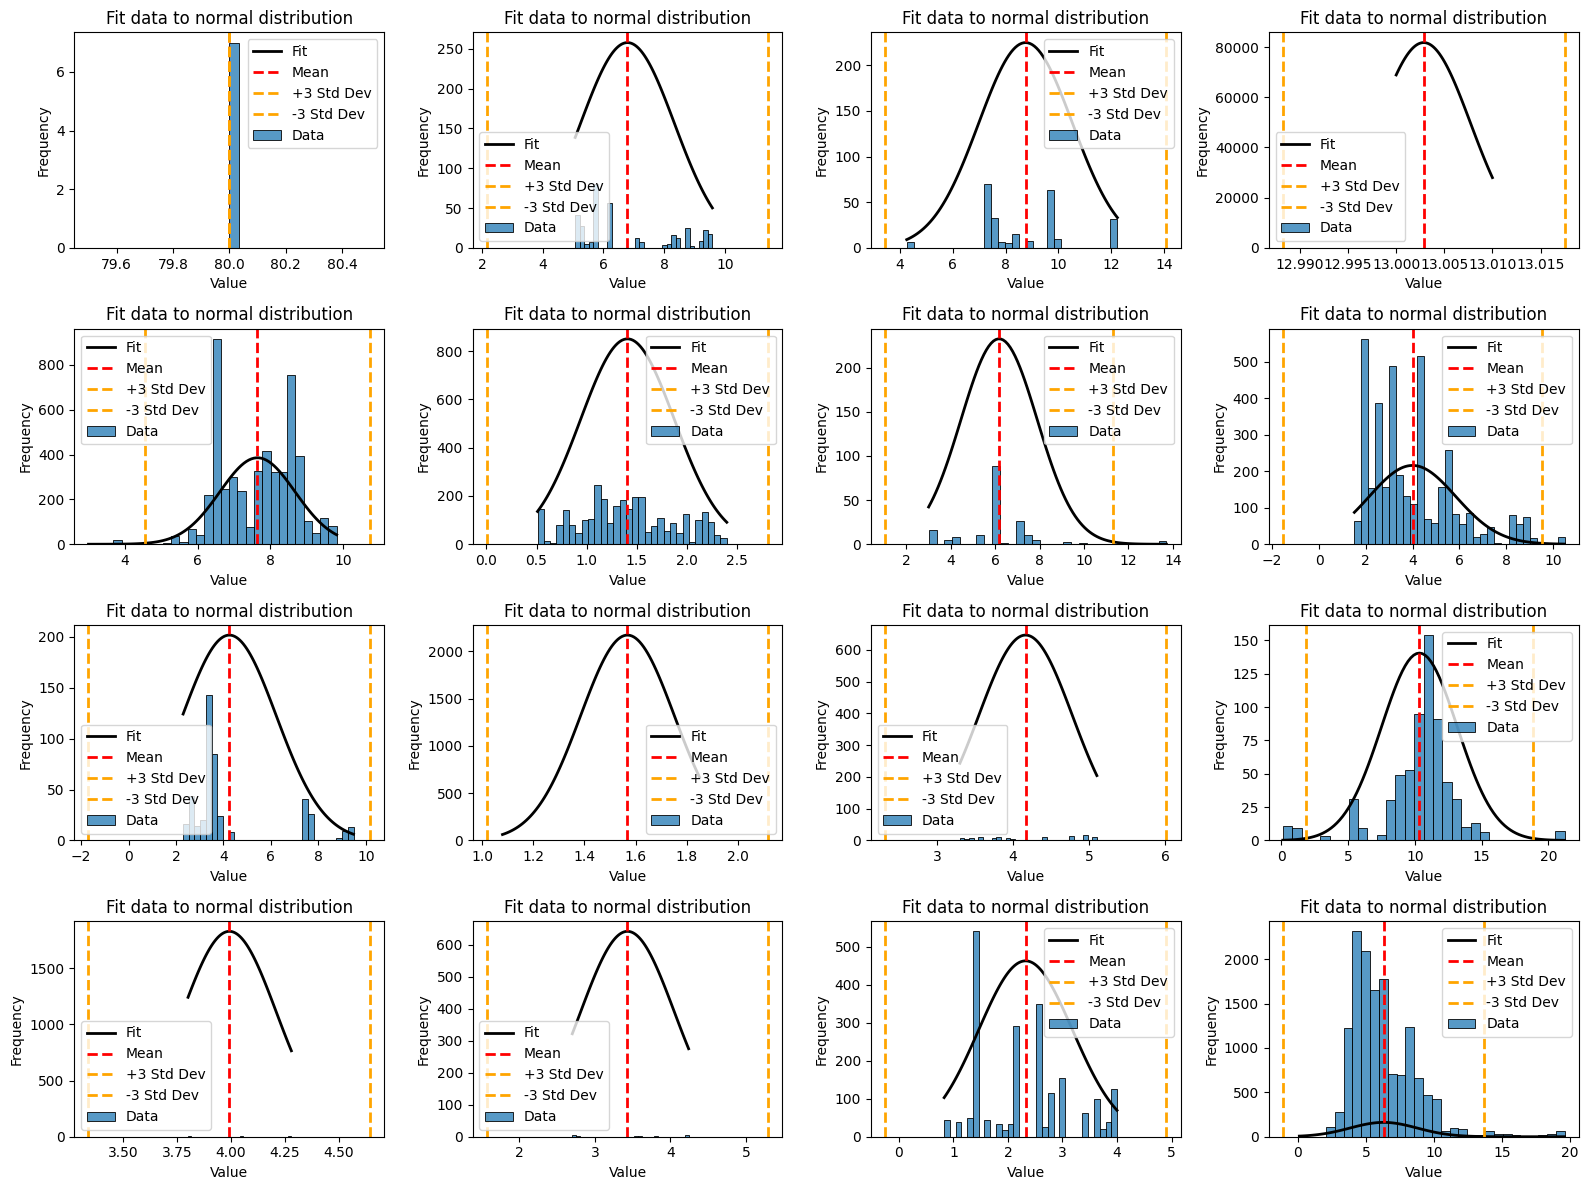

In [9]:
Show_all_Normal_distribution(Sales_stat,4,4)

## 问题一：相关性分析

In [10]:
# 统计不同产品的总销量
Stat_according_to_each_product = Sales_stat_filtered.groupby('单品名称')['销量(千克)'].sum().reset_index()
print("根据不同产品的销售统计数据")
Stat_according_to_each_product.head()

根据不同产品的销售统计数据


,单品名称,销量(千克)
0,七彩椒(1),260.538
1,七彩椒(2),368.000
2,七彩椒(份),18.000
3,上海青,7545.795
4,上海青(份),3070.000


根据不同品类的销售统计数据


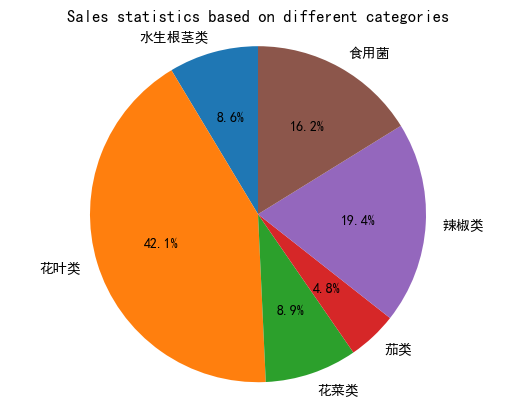

,品类名称,销量(千克)
0,水生根茎类,40235.270
1,花叶类,196700.759
2,花菜类,41427.987
3,茄类,22340.298
4,辣椒类,90709.195
5,食用菌,75561.710


In [13]:
# 统计不同品类的总销量
Stat_according_to_each_Type = Sales_stat_filtered.groupby('品类名称')['销量(千克)'].sum().reset_index()
print("根据不同品类的销售统计数据")

# 绘图
labels = Stat_according_to_each_Type['品类名称']  # 使用翻译后的标签
sizes = Stat_according_to_each_Type['销量(千克)']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Sales statistics based on different categories')
plt.show()

Stat_according_to_each_Type

In [14]:
# 进行每日数据统计
Daily_sales_stat_product = Sales_stat_filtered.groupby(['销售日期', '单品名称']).agg({
    '销量(千克)': 'sum',
    '销售单价(元/千克)': 'sum'
}).reset_index()
Daily_sales_stat_product = Daily_sales_stat_product.rename(columns={
    '销量(千克)': '日销量(千克)',
    '销售单价(元/千克)':'日销售金额(元)'
})

Daily_sales_stat_product = pd.merge(Daily_sales_stat_product, Product_stat, on='单品名称')
print("根据每日销售量的日销量/日销售额统计")
Daily_sales_stat_product.head()

根据每日销售量的日销量/日销售额统计


,销售日期,单品名称,日销量(千克),日销售金额(元),单品编码,分类编码,分类名称
0,2020-07-01,七彩椒(1),1.909,80.0,102900005117209,1011010504,辣椒类
1,2020-07-02,七彩椒(1),1.825,70.0,102900005117209,1011010504,辣椒类
2,2020-07-03,七彩椒(1),1.581,56.0,102900005117209,1011010504,辣椒类
3,2020-07-04,七彩椒(1),0.693,28.0,102900005117209,1011010504,辣椒类
4,2020-07-05,七彩椒(1),1.395,70.0,102900005117209,1011010504,辣椒类


In [15]:
# 根据品类统计的每日销售量
Daily_sales_stat_Type = Daily_sales_stat_product.groupby(['销售日期', '分类名称']).agg({
    '日销量(千克)': 'sum',
    '日销售金额(元)': 'sum'
}).reset_index()
Daily_sales_stat_Type.head()

,销售日期,分类名称,日销量(千克),日销售金额(元)
0,2020-07-01,水生根茎类,4.850,209.6
1,2020-07-01,花叶类,205.402,3383.7
2,2020-07-01,花菜类,46.640,1322.0
3,2020-07-01,茄类,35.374,304.0
4,2020-07-01,辣椒类,76.715,3206.2


### 相关性分析

In [16]:
# 定义交叉相关性计算函数
def cross_corr_scipy(df_a,df_b):
    x = df_a.values
    y = df_b.values
    # 计算均值
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # 中心化时间序列（去均值）
    x_centered = x - mean_x
    y_centered = y - mean_y

    # 初始化交叉相关性数组
    cross_corr = np.zeros(2 * len(x) - 1)
    lags = np.arange(-len(x) + 1, len(x))

    # 计算交叉相关性
    for k in range(len(lags)):
        lag = lags[k]
        if lag < 0:
            x_slice = x_centered[:lag + len(x)]
            y_slice = y_centered[-lag:]
        elif lag > 0:
            x_slice = x_centered[lag:]
            y_slice = y_centered[:len(x) - lag]
        else:
            x_slice = x_centered
            y_slice = y_centered

        norm_factor = np.sqrt(np.sum(x_slice ** 2) * np.sum(y_slice ** 2))
        cross_corr[k] = np.sum(x_slice * y_slice) / norm_factor if norm_factor != 0 else 0

    # 绘图
    plt.figure()
    plt.stem(lags, cross_corr)
    #plt.plot(lags, cross_corr, 'r-', linewidth=2)  # 使用平滑的折线图
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title('Cross-correlation between x and y')
    plt.show()
    print(np.mean(cross_corr**2))

In [17]:
# 使用条件筛选
# 对基于品类分类的相关性分析
filtered_root_stock = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '水生根茎类']
filtered_Mosaic_leaf_class = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '花叶类']
filtered_flower_vegetables = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '花菜类']
filtered_solanaceous = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '茄类']
filtered_Chili_peppers = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '辣椒类']
filtered_mushroomss = Daily_sales_stat_Type[Daily_sales_stat_Type['分类名称'] == '食用菌']

Daily_sales_KG_root_stock = pd.DataFrame()
Daily_sales_KG_Mosaic_leaf_class = pd.DataFrame()
Daily_sales_KG_flower_vegetables = pd.DataFrame()
Daily_sales_KG_solanaceous = pd.DataFrame()
Daily_sales_KG_Chili_peppers = pd.DataFrame()
Daily_sales_KG_mushroomss = pd.DataFrame()
Date_series = pd.DataFrame()

Daily_sales_KG_root_stock['水生根茎类_KG'] = filtered_root_stock["日销量(千克)"]
Daily_sales_KG_Mosaic_leaf_class['花叶类_KG'] = filtered_Mosaic_leaf_class["日销量(千克)"]
Daily_sales_KG_flower_vegetables['花菜类_KG'] = filtered_flower_vegetables["日销量(千克)"]
Daily_sales_KG_solanaceous['茄类_KG'] = filtered_solanaceous["日销量(千克)"]
Daily_sales_KG_Chili_peppers['辣椒类_KG'] = filtered_Chili_peppers["日销量(千克)"]
Daily_sales_KG_mushroomss['食用菌_KG'] = filtered_mushroomss["日销量(千克)"]
Date_series['销售日期'] = Daily_sales_stat_Type["销售日期"]
Date_series = Date_series.drop_duplicates(subset=["销售日期"])

Date_series = Date_series.reset_index(drop=True)
Daily_sales_KG_root_stock = Daily_sales_KG_root_stock.reset_index(drop=True)
Daily_sales_KG_Mosaic_leaf_class = Daily_sales_KG_Mosaic_leaf_class.reset_index(drop=True)
Daily_sales_KG_flower_vegetables = Daily_sales_KG_flower_vegetables.reset_index(drop=True)
Daily_sales_KG_solanaceous = Daily_sales_KG_solanaceous.reset_index(drop=True)
Daily_sales_KG_Chili_peppers = Daily_sales_KG_Chili_peppers.reset_index(drop=True)
Daily_sales_KG_mushroomss = Daily_sales_KG_mushroomss.reset_index(drop=True)

In [18]:
Saled_KG_according_category_data = pd.DataFrame()
Saled_KG_according_category_data = pd.concat([Date_series, 
                         Daily_sales_KG_root_stock, 
                         Daily_sales_KG_Mosaic_leaf_class, 
                         Daily_sales_KG_flower_vegetables, 
                         Daily_sales_KG_solanaceous, 
                         Daily_sales_KG_Chili_peppers, 
                         Daily_sales_KG_mushroomss],  axis=1)
Saled_KG_according_category_data = Saled_KG_according_category_data.set_index("销售日期")
Saled_KG_according_category_data = Saled_KG_according_category_data.dropna()

Saled_KG_according_category_data.head()

,水生根茎类_KG,花叶类_KG,花菜类_KG,茄类_KG,辣椒类_KG,食用菌_KG
销售日期,,,,,,
2020-07-01,4.850,205.402,46.640,35.374,76.715,35.365
2020-07-02,4.600,196.970,43.943,32.199,66.064,48.510
2020-07-03,9.572,187.301,42.076,35.896,64.253,42.442
2020-07-04,5.439,231.679,55.662,57.067,81.282,47.262
2020-07-05,4.019,220.274,55.474,61.816,98.496,73.213


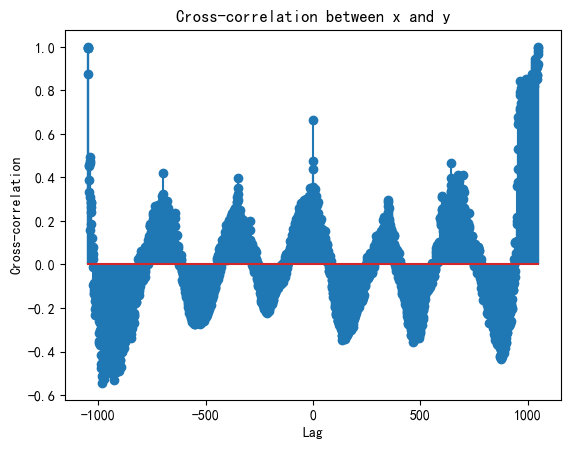

0.07306021005788725


In [19]:
cross_corr_scipy(Saled_KG_according_category_data['水生根茎类_KG'],Saled_KG_according_category_data['食用菌_KG'])

## 问题二：最优化决策模型

In [20]:
Sales_stat_OPT_Raw = Sales_stat_filtered[Sales_stat_filtered["是否打折销售"]=='否']
columns_to_drop = ['均值', '标准差']
Sales_stat_OPT_Raw = Sales_stat_OPT_Raw.drop(columns=columns_to_drop)
Sales_stat_OPT_Raw.head()

,扫码销售时间,单品编码,新码,销量(千克),销售单价(元/千克),销售类型,是否打折销售,单品名称,品类名称,批发单价,折损量,单品成本,单次成本,单次销售额,单次利润率
销售日期,,,,,,,,,,,,,,,
2020-07-01,9:15:08,1.029000e+14,4.401310e+19,0.396,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.841068,3.0096,1.634704
2020-07-01,9:17:27,1.029000e+14,4.401310e+19,0.849,3.2,销售,否,大白菜,花叶类,2.10,22.27,2.701660,2.293709,2.7168,1.184457
2020-07-01,9:17:34,1.029000e+14,4.401310e+19,0.409,7.6,销售,否,泡泡椒(精品),辣椒类,4.32,7.08,4.649161,1.901507,3.1084,1.634704
2020-07-01,9:19:45,1.029000e+14,4.401310e+19,0.421,10.0,销售,否,上海青,花叶类,7.03,14.43,8.215496,3.458724,4.2100,1.217212
2020-07-01,9:20:24,1.029000e+14,4.401310e+19,0.539,8.0,销售,否,菜心,花叶类,4.60,13.70,5.330243,2.873001,4.3120,1.500870


In [21]:
# 计算利润率（加成售价）
Profit_wighted_grouped = Sales_stat_OPT_Raw.groupby([Sales_stat_OPT_Raw.index, '品类名称'])
Profit_wighted_stat = Profit_wighted_grouped.agg(
    销售量之和=pd.NamedAgg(column='销量(千克)', aggfunc='sum'),
    单次成本之和=pd.NamedAgg(column='单次成本', aggfunc='sum'),
    单次销售额之和=pd.NamedAgg(column='单次销售额', aggfunc='sum'),
    总成本 = pd.NamedAgg(column='单次成本', aggfunc='sum'),
).reset_index()

Profit_wighted_stat['单价'] = (Profit_wighted_stat['单次销售额之和'] / Profit_wighted_stat['销售量之和'])
Profit_wighted_stat['平均成本'] = (Profit_wighted_stat['总成本'] / Profit_wighted_stat['销售量之和'])

# 将计算结果放入一个新的DataFrame
Profit_wighted_stat = Profit_wighted_stat[['销售日期', '品类名称', '销售量之和', '单价','平均成本']]
Profit_wighted_stat.set_index('销售日期', inplace=True)
Profit_wighted_stat.head()

,品类名称,销售量之和,单价,平均成本
销售日期,,,,
2020-07-01,水生根茎类,4.850,14.491505,12.622563
2020-07-01,花叶类,191.717,7.545755,5.717106
2020-07-01,花菜类,46.640,12.704331,9.420016
2020-07-01,茄类,35.374,4.998530,4.346075
2020-07-01,辣椒类,76.715,9.906670,5.773350


In [22]:
# 统计不同品类的销售量-利润率
filtered_Profit_root_stock = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '水生根茎类']
filtered_Profit_Mosaic_leaf_class = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '花叶类']
filtered_Profit_flower_vegetables = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '花菜类']
filtered_Profit_solanaceous = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '茄类']
filtered_Profit_Chili_peppers = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '辣椒类']
filtered_Profit_mushroomss = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == '食用菌']

#构建空的DataFrame
Profit_root_stock = pd.DataFrame()
Profit_Mosaic_leaf_class = pd.DataFrame()
Profit_flower_vegetables = pd.DataFrame()
Profit_solanaceous = pd.DataFrame()
Profit_Chili_peppers = pd.DataFrame()
Profit_mushroomss = pd.DataFrame()
Sell_root_stock = pd.DataFrame()
Sell_Mosaic_leaf_class = pd.DataFrame()
Sell_flower_vegetables = pd.DataFrame()
Sell_solanaceous = pd.DataFrame()
Sell_Chili_peppers = pd.DataFrame()
Sell_mushroomss = pd.DataFrame()
Cost_root_stock = pd.DataFrame()
Cost_Mosaic_leaf_class = pd.DataFrame()
Cost_flower_vegetables = pd.DataFrame()
Cost_solanaceous = pd.DataFrame()
Cost_Chili_peppers = pd.DataFrame()
Cost_mushroomss = pd.DataFrame()

Profit_root_stock['水生根茎类_售价'] = filtered_Profit_root_stock["单价"]
Profit_Mosaic_leaf_class['花叶类_售价'] = filtered_Profit_Mosaic_leaf_class["单价"]
Profit_flower_vegetables['花菜类_售价'] = filtered_Profit_flower_vegetables["单价"]
Profit_solanaceous['茄类_售价'] = filtered_Profit_solanaceous["单价"]
Profit_Chili_peppers['辣椒类_售价'] = filtered_Profit_Chili_peppers["单价"]
Profit_mushroomss['食用菌_售价'] = filtered_Profit_mushroomss["单价"]

Sell_root_stock['水生根茎类_KG'] = filtered_Profit_root_stock["销售量之和"]
Sell_Mosaic_leaf_class['花叶类_KG'] = filtered_Profit_Mosaic_leaf_class["销售量之和"]
Sell_flower_vegetables['花菜类_KG'] = filtered_Profit_flower_vegetables["销售量之和"]
Sell_solanaceous['茄类_KG'] = filtered_Profit_solanaceous["销售量之和"]
Sell_Chili_peppers['辣椒类_KG'] = filtered_Profit_Chili_peppers["销售量之和"]
Sell_mushroomss['食用菌_KG'] = filtered_Profit_mushroomss["销售量之和"]

Cost_root_stock['水生根茎类_Cost'] = filtered_Profit_root_stock["平均成本"]
Cost_Mosaic_leaf_class['花叶类_Cost'] = filtered_Profit_Mosaic_leaf_class["平均成本"]
Cost_flower_vegetables['花菜类_Cost'] = filtered_Profit_flower_vegetables["平均成本"]
Cost_solanaceous['茄类_Cost'] = filtered_Profit_solanaceous["平均成本"]
Cost_Chili_peppers['辣椒类_Cost'] = filtered_Profit_Chili_peppers["平均成本"]
Cost_mushroomss['食用菌_Cost'] = filtered_Profit_mushroomss["平均成本"]

In [23]:
Profit_KG_stat_root_stock = pd.DataFrame()
Profit_KG_stat_Mosaic_leaf_class = pd.DataFrame()
Profit_KG_stat_flower_vegetables = pd.DataFrame()
Profit_KG_stat_solanaceous = pd.DataFrame()
Profit_KG_stat_Chili_peppers = pd.DataFrame()
Profit_KG_stat_mushroomss = pd.DataFrame()

Profit_KG_stat_root_stock = pd.concat([
                         Profit_root_stock, 
                         Sell_root_stock,Cost_root_stock
                         ],  axis=1)

Profit_KG_stat_Mosaic_leaf_class = pd.concat([
                         Profit_Mosaic_leaf_class, 
                         Sell_Mosaic_leaf_class,Cost_Mosaic_leaf_class
                         ],  axis=1)

Profit_KG_stat_flower_vegetables = pd.concat([
                         Profit_flower_vegetables, 
                         Sell_flower_vegetables,Cost_flower_vegetables
                         ],  axis=1)

Profit_KG_stat_solanaceous = pd.concat([
                         Profit_solanaceous, 
                         Sell_solanaceous,Cost_solanaceous
                         ],  axis=1)

Profit_KG_stat_Chili_peppers = pd.concat([
                         Profit_Chili_peppers, 
                         Sell_Chili_peppers,Cost_Chili_peppers
                         ],  axis=1)

Profit_KG_stat_mushroomss = pd.concat([
                         Profit_mushroomss, 
                         Sell_mushroomss,Cost_mushroomss
                         ],  axis=1)

Target_frame_list = [Profit_KG_stat_root_stock,
                     Profit_KG_stat_Mosaic_leaf_class,
                     Profit_KG_stat_flower_vegetables,
                     Profit_KG_stat_solanaceous,
                     Profit_KG_stat_Chili_peppers,
                     Profit_KG_stat_mushroomss]

In [24]:
def add_profit_Dataframe(Dataframe):
    Dataframe['利润率'] = pd.DataFrame(Dataframe.iloc[:, 0] / Dataframe.iloc[:, 2])-1
    return Dataframe

for frame in Target_frame_list:
    add_profit_Dataframe(frame)

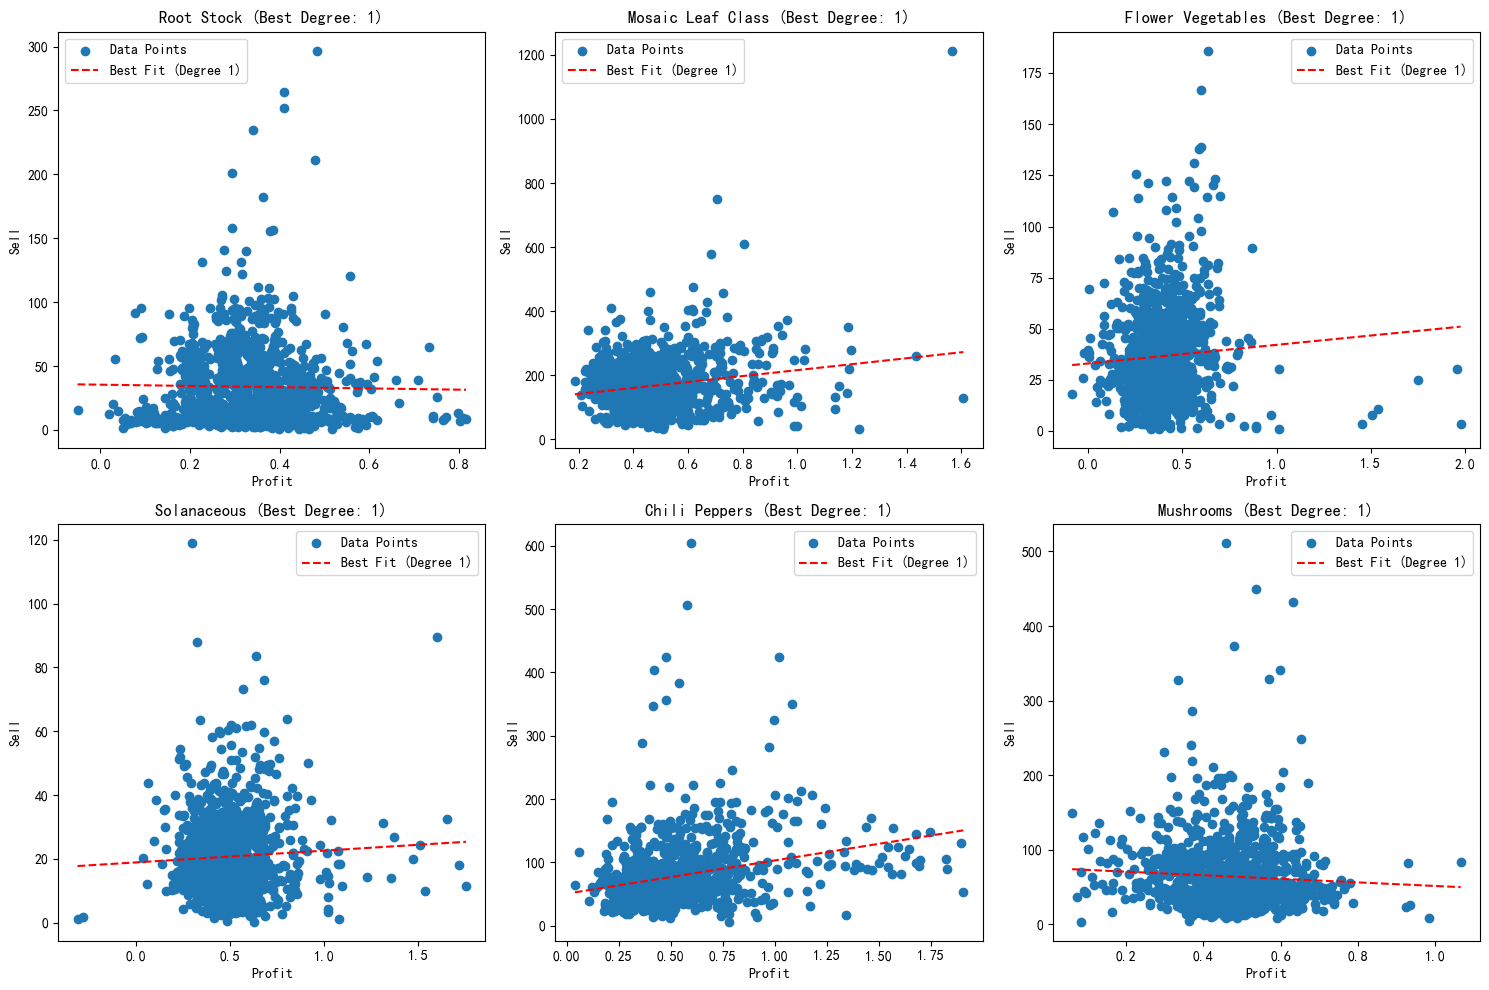

Best fit equations:
Root Stock:  
-4.869 x + 35.37
Mosaic Leaf Class:  
92.79 x + 123.2
Flower Vegetables:  
9.122 x + 32.89
Solanaceous:  
3.688 x + 18.86
Chili Peppers:  
52.49 x + 50.52
Mushrooms:  
-23.98 x + 75.07


In [25]:
# 计算利润率和销售量之间的关系
# 创建一个2x3的subplot，高为2，宽为3
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 使用一个字典来存储所有的DataFrame，这样我们可以使用一个循环来绘制所有的图
data_dict = {
    'Root Stock': Profit_KG_stat_root_stock,
    'Mosaic Leaf Class': Profit_KG_stat_Mosaic_leaf_class,
    'Flower Vegetables': Profit_KG_stat_flower_vegetables,
    'Solanaceous': Profit_KG_stat_solanaceous,
    'Chili Peppers': Profit_KG_stat_Chili_peppers,
    'Mushrooms': Profit_KG_stat_mushroomss
}

best_fit_equations = {}  # 用于存储最佳拟合公式

# 循环通过字典绘制每个图
for i, (key, df) in enumerate(data_dict.items()):
    ax = axs[i//3, i%3]
    
    # 提取数据
    x = df.iloc[:, 3].values  
    y = df.iloc[:, 1].values  
    
    # 创建散点图
    ax.scatter(x, y, label='Data Points')
    
    min_mse = float('inf')
    best_degree = 0
    best_p = None
    
    # 尝试从1到6阶多项式
    for degree in range(0,2):
        z = np.polyfit(x, y, degree)
        p = np.poly1d(z)
        mse = mean_squared_error(y, p(x))
        
        if mse < min_mse:
            min_mse = mse
            best_degree = degree
            best_p = p
    
    # 绘制最佳拟合线
    xp = np.linspace(min(x), max(x), 100)
    ax.plot(xp, best_p(xp), '--',color="r", label=f'Best Fit (Degree {best_degree})')
    
    best_fit_equations[key] = best_p

    # 设置图的其他元素
    ax.set_title(f'{key} (Best Degree: {best_degree})')
    ax.set_xlabel('Profit')
    ax.set_ylabel('Sell')
    ax.legend()

plt.tight_layout()
plt.show()

# 单独输出最佳拟合公式
print("Best fit equations:")
for key, equation in best_fit_equations.items():
    print(f"{key}: {equation}")

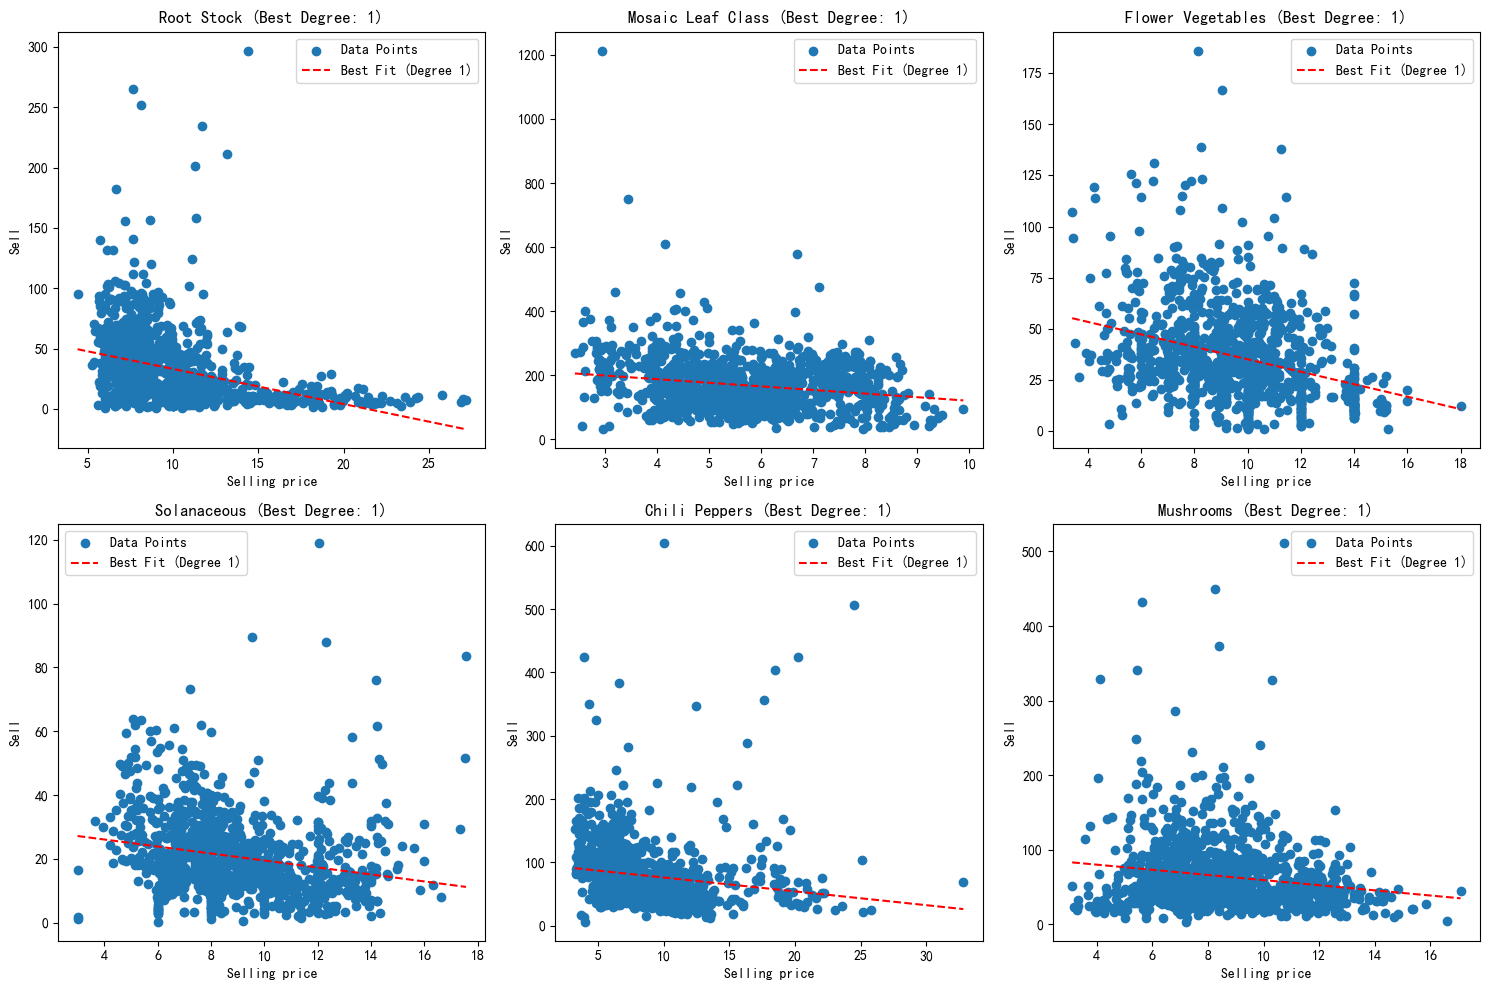

Best fit equations:
Root Stock:  
-2.914 x + 62.26
Mosaic Leaf Class:  
-11.24 x + 232.6
Flower Vegetables:  
-3.054 x + 65.47
Solanaceous:  
-1.096 x + 30.43
Chili Peppers:  
-2.18 x + 97.75
Mushrooms:  
-3.453 x + 93.52


In [26]:
# 创建一个2x3的subplot，高为2，宽为3
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 使用一个字典来存储所有的DataFrame，这样我们可以使用一个循环来绘制所有的图
data_dict = {
    'Root Stock': Profit_KG_stat_root_stock,
    'Mosaic Leaf Class': Profit_KG_stat_Mosaic_leaf_class,
    'Flower Vegetables': Profit_KG_stat_flower_vegetables,
    'Solanaceous': Profit_KG_stat_solanaceous,
    'Chili Peppers': Profit_KG_stat_Chili_peppers,
    'Mushrooms': Profit_KG_stat_mushroomss
}

best_fit_equations = {}  # 用于存储最佳拟合公式

# 循环通过字典绘制每个图
for i, (key, df) in enumerate(data_dict.items()):
    ax = axs[i//3, i%3]
    
    # 提取数据
    x = df.iloc[:, 0].values  # 假设第一列是利润率
    y = df.iloc[:, 1].values  # 假设第二列是销售量
    
    # 创建散点图
    ax.scatter(x, y, label='Data Points')
    
    min_mse = float('inf')
    best_degree = 0
    best_p = None
    
    # 尝试从1到6阶多项式
    for degree in range(0, 2):
        z = np.polyfit(x, y, degree)
        p = np.poly1d(z)
        mse = mean_squared_error(y, p(x))
        
        if mse < min_mse:
            min_mse = mse
            best_degree = degree
            best_p = p
    
    # 绘制最佳拟合线
    xp = np.linspace(min(x), max(x), 100)
    ax.plot(xp, best_p(xp), '--',color="r", label=f'Best Fit (Degree {best_degree})')
    
    best_fit_equations[key] = best_p

    # 设置图的其他元素
    ax.set_title(f'{key} (Best Degree: {best_degree})')
    ax.set_xlabel('Selling price')
    ax.set_ylabel('Sell')
    ax.legend()

plt.tight_layout()
plt.show()

# 单独输出最佳拟合公式
print("Best fit equations:")
for key, equation in best_fit_equations.items():
    print(f"{key}: {equation}")

In [27]:
#  根据上面得出的 售价-销量一阶回归方程进行函数实现
def Root_stock_prediction(x):
    return -2.914*x + 62.26

def Mosaic_Leaf_prediction(x):
    return -11.24*x + 232.6

def Flower_Vegetables_prediction(x):
    return -1.096*x + 65.47

def Solanaceous_prediction(x):
    return -2.18*x + 30.43

def Chili_Peppers_prediction(x):
    return -2.18*x + 97.75

def Mushrooms_prediction(x):
    return -3.453*x + 93.52

### 训练神经网络模型用于预测成本
- 我们需要通过季节（二十四节气）和产品过去价格的时间序列，用于预测产品的采购成本
- 本模型使用特征融合算法，TCN时序卷积算法，注意力机制算法

In [28]:
# 迁移前面预处理得到的Dataframe结果用于神经网络模型的构建
Profit_KG_stat_root_stock_train = Profit_KG_stat_root_stock
Profit_KG_stat_Mosaic_leaf_class_train = Profit_KG_stat_Mosaic_leaf_class
Profit_KG_stat_flower_vegetables_train = Profit_KG_stat_flower_vegetables
Profit_KG_stat_solanaceous_train = Profit_KG_stat_solanaceous
Profit_KG_stat_Chili_peppers_train = Profit_KG_stat_Chili_peppers
Profit_KG_stat_mushroomss_train = Profit_KG_stat_mushroomss
Target_frame_train_list = [Profit_KG_stat_root_stock_train,
                     Profit_KG_stat_Mosaic_leaf_class_train,
                     Profit_KG_stat_flower_vegetables_train,
                     Profit_KG_stat_solanaceous_train,
                     Profit_KG_stat_Chili_peppers_train,
                     Profit_KG_stat_mushroomss_train]

In [29]:
# 二十四节气及其对应的月和日
solar_terms = [
    ("立春", (2, 4)), ("雨水", (2, 19)),
    ("惊蛰", (3, 5)), ("春分", (3, 20)),
    ("清明", (4, 4)), ("谷雨", (4, 20)),
    ("立夏", (5, 5)), ("小满", (5, 21)),
    ("芒种", (6, 5)), ("夏至", (6, 21)),
    ("小暑", (7, 6)), ("大暑", (7, 22)),
    ("立秋", (8, 7)), ("处暑", (8, 23)),
    ("白露", (9, 7)), ("秋分", (9, 22)),
    ("寒露", (10, 8)), ("霜降", (10, 23)),
    ("立冬", (11, 7)), ("小雪", (11, 22)),
    ("大雪", (12, 6)), ("冬至", (12, 21)),
    ("小寒", (1, 5)), ("大寒", (1, 20))
]

# 季节和节气的映射
season_to_terms = {
    '春': ["立春", "雨水", "惊蛰", "春分", "清明", "谷雨"],
    '夏': ["立夏", "小满", "芒种", "夏至", "小暑", "大暑"],
    '秋': ["立秋", "处暑", "白露", "秋分", "寒露", "霜降"],
    '冬': ["立冬", "小雪", "大雪", "冬至", "小寒", "大寒"]
}

def find_previous_solar_term(month, day):
    for i in reversed(range(len(solar_terms))):
        term, (term_month, term_day) = solar_terms[i]
        if (month, day) >= (term_month, term_day):
            return term
    return None

def encode_solar_term(month, day):
    term = find_previous_solar_term(month, day)
    if term is None:
        return [0]*10
    
    for season, terms in season_to_terms.items():
        if term in terms:
            season_encoding = [1 if s == season else 0 for s in ['春', '夏', '秋', '冬']]
            term_encoding = [1 if t == term else 0 for t in terms]
            return season_encoding + term_encoding
    return [0]*10

In [30]:
# 对所有的品类的数据中的日期进行二十四节气编码 准备进行数据预处理
for frame in Target_frame_train_list:
    frame['二十四节气编码'] = frame.index.map(lambda x: encode_solar_term(x.month, x.day))

In [31]:
def slide_windows(Dataframe,window_size):
    processed_df = pd.DataFrame()
    Total_size = window_size+7
    # 滑动窗口
    for i in range(len(Dataframe) - 22):  # 15天成本 + 7天预测 = 22天窗口
        # 获取过去15天的成本数据
        past_15_days_cost = Dataframe.iloc[:, 2].iloc[i:i+window_size].values

        # 获取未来7天的节气数据
        future_7_days_solar_term = np.array(Dataframe.iloc[:, 4].iloc[i+window_size:i+Total_size].tolist())

        # 将两个数组合并为一个DataFrame行
        row_data = {
            '过去时间窗口成本': list(past_15_days_cost),
            '未来七天节气': future_7_days_solar_term.reshape(-1).tolist(),  # 将7x10的二维数组转换为1D数组
            '未来七天成本': list(Dataframe.iloc[:, 2].iloc[i+window_size:i+Total_size].values)
        }
        processed_df = processed_df.append(row_data, ignore_index=True)
    return processed_df

In [32]:
Target_frame_train_list_slided = []
for frame in Target_frame_train_list:
    Target_frame_train_list_slided.append(slide_windows(frame,15))

C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\1534860753.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  processed_df = processed_df.append(row_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\1534860753.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  processed_df = processed_df.append(row_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\1534860753.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  processed_df = processed_df.append(row_data, ignore_index=True)
C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\1534860753.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [33]:
Scaler_diction_global = {}

def normalize_list(scaler, lst):
    arr = np.array(lst).reshape(-1, 1)
    arr_scaled = scaler.fit_transform(arr)
    return arr_scaled.flatten().tolist()

def MinMaxScaler_prepossecing(DataFrame,name_type):
    scaler_future_cost = MinMaxScaler()
    scaler_future_solar_term = MinMaxScaler()
    scaler_past_cost = MinMaxScaler()
    DataFrame['未来七天成本'] = DataFrame['未来七天成本'].apply(lambda x: normalize_list(scaler_future_cost, x))
    DataFrame['未来七天节气'] = DataFrame['未来七天节气'].apply(lambda x: normalize_list(scaler_future_solar_term, x))
    DataFrame['过去时间窗口成本'] = DataFrame['过去时间窗口成本'].apply(lambda x: normalize_list(scaler_past_cost, x))
    Scaler_diction_global.update({name_type: [scaler_future_cost,
                                             scaler_future_solar_term,
                                             scaler_past_cost]}) 
    return DataFrame

name_type_list = ['水生根茎类','花叶类','花菜类','茄类','辣椒类','食用菌']
Target_frame_train_list_slided_normalized = []
for index in range(len(Target_frame_train_list_slided)):
    Target_frame_train_list_slided_normalized.append(MinMaxScaler_prepossecing(Target_frame_train_list_slided[index],
                                                                               name_type_list[index]))

### 神经网络数据进一步预处理，让数据可以在模型这种运行

In [34]:
def deal_X2(Dataframe):
    list_test = []
    for temp in np.array(Dataframe['未来七天节气']):
        for i in temp:
            list_test.append(i)
    X2 = np.array(list_test).reshape(-1, 70, 1)
    return X2

def df_to_nparray(df_col):
    return np.array([np.array(x) for x in df_col])

def Data_process_defore_train(Dataframe):
    # 获取数据集总长度
    n = len(Dataframe)
    # 计算测试集、验证集和训练集的大小
    test_size = int(n * 0.2)
    val_size = int(n * 0.8 * 0.25)
    train_size = n - test_size - val_size

    # 分离自变量和因变量
    X = Dataframe[["未来七天节气", "过去时间窗口成本"]]
    y = Dataframe["未来七天成本"]

    # 按照顺序切分数据集
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]

    X_val = X.iloc[train_size:train_size+val_size]
    y_val = y.iloc[train_size:train_size+val_size]

    X_test = X.iloc[train_size+val_size:]
    y_test = y.iloc[train_size+val_size:]

    # 打印各个数据集的大小
    print("Training set:", X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, y_val.shape)
    print("Test set:", X_test.shape, y_test.shape)
    # 确保X_train, y_train, X_val, y_val, X_test, y_test都已正确加载并预处理
    X1_train = df_to_nparray(X_train['过去时间窗口成本']).reshape(-1, 15, 1)
    X2_train = deal_X2(X_train)
    y_train_array = df_to_nparray(y_train).reshape(-1, 7)

    X1_val = df_to_nparray(X_val['过去时间窗口成本']).reshape(-1, 15, 1)
    X2_val = deal_X2(X_val)

    y_val_array = df_to_nparray(y_val).reshape(-1, 7)

    X1_test = df_to_nparray(X_test['过去时间窗口成本']).reshape(-1, 15, 1)
    X2_test = deal_X2(X_test)

    y_test_array = df_to_nparray(y_test).reshape(-1, 7)
    return {"X1训练集":X1_train,
            "X2训练集":X2_train,
            "X1验证集":X1_val,
            "X2验证集":X2_val,
            "X1测试集":X1_test,
            "X2测试集":X2_test,
            "Y训练集":y_train_array,
            "Y验证集":y_val_array,
            "Y测试集":y_test_array}

### 构造模型

In [35]:
# 注意力机制层
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer='zeros', trainable=True)
        
    def call(self, inputs):
        q = tf.nn.tanh(tf.linalg.matmul(inputs, self.W) + self.b)
        a = tf.nn.softmax(q, axis=1)
        output = tf.reduce_sum(a * inputs, axis=1)
        return output

class Feature_fusion_TCN_model(Model):
    def __init__(self):
        super(Feature_fusion_TCN_model, self).__init__()
        
        self.tcn1 = TCN()
        self.tcn2 = TCN()
        
        self.concat = layers.Concatenate(axis=1)
        self.attention_layer = AttentionLayer()
        
        self.reshape = layers.Reshape((1, -1))
        self.output_layer = Dense(7, activation='linear')
        
    def call(self, inputs):
        input1, input2 = inputs

        tcn1_output = self.tcn1(input1)
        tcn2_output = self.tcn2(input2)

        merged = self.concat([tcn1_output, tcn2_output])
        
        attention_output = self.attention_layer(merged)
        attention_output_expanded = self.reshape(attention_output)
        
        output = self.output_layer(attention_output_expanded)
        
        return output

In [36]:
print("模型的顺序为：",name_type_list)
model_root_stock = Feature_fusion_TCN_model()
model_root_stock.compile(optimizer='adam', loss='mse')
model_root_stock.build([(None, 15, 1), (None, 70, 1)]) 

model_flower_leaf = Feature_fusion_TCN_model()
model_flower_leaf.compile(optimizer='adam', loss='mse')
model_flower_leaf.build([(None, 15, 1), (None, 70, 1)]) 

model_flower_veg = Feature_fusion_TCN_model()
model_flower_veg.compile(optimizer='adam', loss='mse')
model_flower_veg.build([(None, 15, 1), (None, 70, 1)]) 

model_Nightshade  = Feature_fusion_TCN_model()
model_Nightshade .compile(optimizer='adam', loss='mse')
model_Nightshade .build([(None, 15, 1), (None, 70, 1)]) 

model_spicy  = Feature_fusion_TCN_model()
model_spicy .compile(optimizer='adam', loss='mse')
model_spicy .build([(None, 15, 1), (None, 70, 1)]) 

model_mushroom  = Feature_fusion_TCN_model()
model_mushroom .compile(optimizer='adam', loss='mse')
model_mushroom .build([(None, 15, 1), (None, 70, 1)]) 

model_list = [model_mushroom,
              model_flower_leaf,
              model_flower_veg,
              model_Nightshade,
              model_spicy,model_mushroom]

print("模型构建完毕，模型结构示例如下：")
model_mushroom.summary()

模型的顺序为： ['水生根茎类', '花叶类', '花菜类', '茄类', '辣椒类', '食用菌']
模型构建完毕，模型结构示例如下：
Model: "feature_fusion_tcn_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_10 (TCN)                multiple                  136256    
                                                                 
 tcn_11 (TCN)                multiple                  136256    
                                                                 
 concatenate_5 (Concatenate)  multiple                 0         
                                                                 
 attention_layer_5 (Attentio  multiple                 16512     
 nLayer)                                                         
                                                                 
 reshape_5 (Reshape)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple

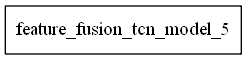

In [37]:
# 模型结构可视化
plot_model(model_mushroom, show_shapes=True, show_layer_names=True)

In [38]:
# Early Stopping 设置
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Training_history = []
for model_index in range(len(model_list)):
    Test_dic = Data_process_defore_train(Target_frame_train_list_slided_normalized[model_index])
    history = model_list[model_index].fit([Test_dic["X1训练集"], Test_dic["X2训练集"]], Test_dic["Y训练集"],
                    epochs=100,
                    batch_size=32,
                    validation_data=([Test_dic["X1验证集"], Test_dic["X2验证集"]], Test_dic["Y验证集"]),
                    callbacks=[early_stopping])
    # 使用测试集评估模型
    test_loss = model_list[model_index].evaluate([Test_dic["X1测试集"], Test_dic["X2测试集"]], Test_dic["Y测试集"])
    print(f"Test loss: {test_loss}")
    Training_history.append(history)

Training set: (639, 2) (639,)
Validation set: (212, 2) (212,)
Test set: (212, 2) (212,)
Epoch 1/100
20/20 [==============================] - 11s 138ms/step - loss: 0.4545 - val_loss: 0.2987
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.3189 - val_loss: 0.2836
Epoch 3/100
20/20 [==============================] - 2s 81ms/step - loss: 0.3034 - val_loss: 0.2689
Epoch 4/100
20/20 [==============================] - 2s 77ms/step - loss: 0.2884 - val_loss: 0.2565
Epoch 5/100
20/20 [==============================] - 2s 83ms/step - loss: 0.2745 - val_loss: 0.2421
Epoch 6/100
20/20 [==============================] - 2s 78ms/step - loss: 0.2610 - val_loss: 0.2305
Epoch 7/100
20/20 [==============================] - 1s 74ms/step - loss: 0.2491 - val_loss: 0.2190
Epoch 8/100
20/20 [==============================] - 1s 76ms/step - loss: 0.2374 - val_loss: 0.2087
Epoch 9/100
20/20 [==============================] - 2s 78ms/step - loss: 0.2268 - val_loss: 0.1997
Epoch 10/1

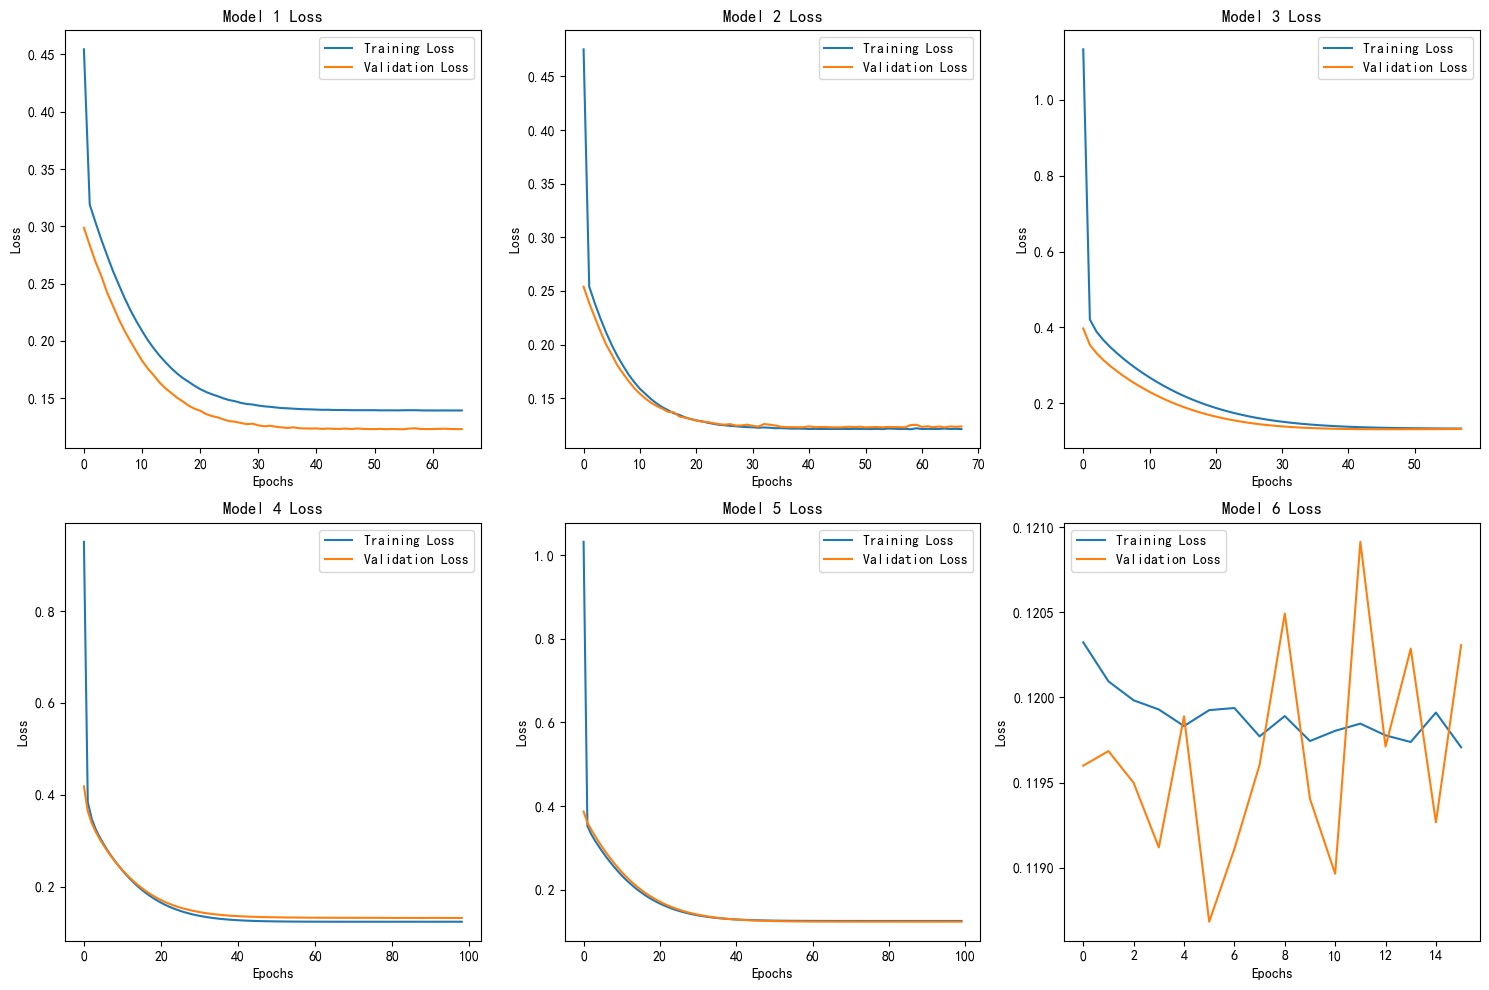

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 遍历所有的模型并绘制
for i, history in enumerate(Training_history):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # 绘制训练集和验证集的准确度/损失值
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    
    # 添加标题和标签
    ax.set_title(f'Model {i+1} Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

# 展示图表
plt.tight_layout()
plt.show()

### 预测模型

- 我们已经对于六个品类分别训练了对应的神经网络模型，现在我们需要基于这个模型进行数据预测
- 根据前面的归一化模型进行反归一化
- 模型顺序为：'水生根茎类', '花叶类', '花菜类', '茄类', '辣椒类', '食用菌'

In [40]:
# 获取未来七天的二十四节气编码
last_date_in_index = Target_frame_train_list[0].index[-1] 
last_date = pd.Timestamp(last_date_in_index) 

future_7_days = pd.date_range(start=last_date, periods=8, freq='D')[1:]
future_7_days

DatetimeIndex(['2023-07-01', '2023-07-02', '2023-07-03', '2023-07-04',
               '2023-07-05', '2023-07-06', '2023-07-07'],
              dtype='datetime64[ns]', freq='D')

In [41]:
solor_tern_7day_future = pd.DataFrame()
solor_tern_7day_future = future_7_days.map(lambda x: encode_solar_term(x.month, x.day))
solor_tern_7day_future = pd.DataFrame(solor_tern_7day_future)
solor_tern_7day_future.columns = ['未来七天节气']
X2_predict = deal_X2(solor_tern_7day_future)

In [47]:
def predict_cost(num):
    Root_stock_prediction = pd.DataFrame()
    last_15_data_root_Stock = Target_frame_train_list_slided_normalized[num].iloc[-1:, 2]
    row_data = {
                '过去时间窗口成本': list(last_15_data_root_Stock.values),
                '未来七天节气': X2_predict 
            }
    Root_stock_prediction = Root_stock_prediction.append(row_data, ignore_index=True)
    X1 = np.array(list(Root_stock_prediction["过去时间窗口成本"])).reshape(-1,15,1)
    prediction_root_stock_finish = model_list[num].predict([X1, X1])
    scaler1 = MinMaxScaler()
    scaled_array = scaler1.fit_transform(Target_frame_train_list[num].iloc[:,2].values.reshape(-1, 1))
    inverse_scaled_array = scaler1.inverse_transform(prediction_root_stock_finish.reshape(-1, 1))
    
    return inverse_scaled_array

In [48]:
Data_predicted_result = pd.DataFrame()
for i in range(6):
    a = predict_cost(i).reshape(1,-1)
    Data_predicted_result[name_type_list[i]] = a[0]
Data_predicted_result_new_index = pd.date_range(start='2023-07-01', periods=len(Data_predicted_result), freq='D')
Data_predicted_result.index = Data_predicted_result_new_index

Data_predicted_result

C:\Users\q0300\AppData\Local\Temp\ipykernel_24992\266553814.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Root_stock_prediction = Root_stock_prediction.append(row_data, ignore_index=True)


ValueError: cannot reshape array of size 7 into shape (15,1)

In [46]:
Target_frame_train_list_slided_normalized[1].iloc[-1:, 2]

1062    [0.0, 0.5912318756141008, 0.5735194304846347, ...
Name: 未来七天成本, dtype: object

### 最优化决策模型

#### 我们需要对其可能的销量进行数学建模，构造一个置信区间用来给销量添加范围限制

In [ ]:
DataFrame_list_type_fillted = {}

for name in name_type_list:
    temp_frame = Profit_wighted_stat[Profit_wighted_stat['品类名称'] == name]["销售量之和"]
    DataFrame_list_type_fillted[name] = temp_frame

In [ ]:
# 定义滑动窗口函数
def slide_window_prepare_data(df, window_size):
    # 初始化一个空的DataFrame来存储结果
    result_df = pd.DataFrame(columns=['过去时间窗口销量', '未来七天销量'])

    for i in range(len(df) - window_size - 6):  # 留出空间以预测未来7天的销售量
        past_window_data = df.iloc[i:i + window_size].tolist()  # 获取window_size大小的窗口数据并转为列表
        future_7_days_data = df.iloc[i + window_size:i + window_size + 7].tolist()  # 获取未来7天的数据并转为列表
        result_df.loc[i] = [past_window_data, future_7_days_data]
            
    return result_df

In [ ]:
def MinMaxScaler_type_sale_prediction(df):
    # 初始化归一化器
    scaler = MinMaxScaler()

    # 提取列并转换为适合归一化的格式
    past_sales_list = np.array(result_df['过去时间窗口销量'].tolist())
    future_sales_list = np.array(result_df['未来七天销量'].tolist())

    # 归一化
    past_sales_list_scaled = scaler.fit_transform(past_sales_list)
    future_sales_list_scaled = scaler.fit_transform(future_sales_list)
    df = pd.DataFrame()
    # 将归一化后的数据转换回DataFrame的原始格式
    df['过去时间窗口销量'] = past_sales_list_scaled.tolist()
    df['未来七天销量'] = future_sales_list_scaled.tolist()
    return df

In [ ]:
DataFrame_list_type_fillted_normalized = {}
for name in name_type_list:
    window_size = 7  # 可以设置为你需要的窗口大小
    result_df = slide_window_prepare_data(DataFrame_list_type_fillted[name], window_size)
    result_df = MinMaxScaler_type_sale_prediction(result_df)
    DataFrame_list_type_fillted_normalized[name] = result_df

In [ ]:
def Data_process_defore_train_tepe_sale(Dataframe):
    # 获取数据集总长度
    n = len(Dataframe)
    # 计算测试集、验证集和训练集的大小
    test_size = int(n * 0.2)
    val_size = int(n * 0.8 * 0.25)
    train_size = n - test_size - val_size

    # 分离自变量和因变量
    X = Dataframe["过去时间窗口销量"]
    y = Dataframe["未来七天销量"]

    # 按照顺序切分数据集
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]

    X_val = X.iloc[train_size:train_size+val_size]
    y_val = y.iloc[train_size:train_size+val_size]

    X_test = X.iloc[train_size+val_size:]
    y_test = y.iloc[train_size+val_size:]

    # 打印各个数据集的大小
    print("Training set:", X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, y_val.shape)
    print("Test set:", X_test.shape, y_test.shape)
    # 确保X_train, y_train, X_val, y_val, X_test, y_test都已正确加载并预处理
    X1_train = df_to_nparray(X_train).reshape(-1, 7, 1)
    y_train_array = df_to_nparray(y_train).reshape(-1, 7)

    X1_val = df_to_nparray(X_val).reshape(-1, 7, 1)

    y_val_array = df_to_nparray(y_val).reshape(-1, 7)

    X1_test = df_to_nparray(X_test).reshape(-1, 7, 1)

    y_test_array = df_to_nparray(y_test).reshape(-1, 7)
    return {"X训练集":X1_train,
            "X验证集":X1_val,
            "X测试集":X1_test,
            "Y训练集":y_train_array,
            "Y验证集":y_val_array,
            "Y测试集":y_test_array}

In [ ]:
DataFrame_list_type_fillted_normalized_train_split = {}
for name in name_type_list:
    DataFrame_list_type_fillted_normalized_train_split[name] = Data_process_defore_train_tepe_sale(DataFrame_list_type_fillted_normalized[name])

In [ ]:
# 搭建模型
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, values, query):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class AttentionTCNModel:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.model = self.build_model()

    def build_model(self):
        input_layer = Input(shape=self.input_shape)

        # TCN 层
        tcn_output = TCN(input_shape=self.input_shape)(input_layer)

        # 注意力层
        context_vector, attention_weights = AttentionLayer(units=128)(tcn_output, tcn_output)

        # 全连接层
        output_layer = Dense(64, activation='relu')(context_vector)
        output_layer = Dense(self.output_shape[1], activation='linear')(output_layer)

        # 构建模型
        model = Model(inputs=input_layer, outputs=output_layer)

        # 编译模型
        model.compile(optimizer='adam', loss='mse')

        return model

    def summary(self):
        self.model.summary()

# 使用
input_shape = (7, 1)
output_shape = (644, 7)  # 注意：这里我们只用输出维度的第二个数字，因为第一个数字（644）是batch_size，它在模型定义时不是必需的。

my_model = AttentionTCNModel(input_shape, output_shape)
my_model.summary()

In [ ]:
History_model_sampling = {}
Model_diction_sampling = {}
# 自动化训练模型

for name in name_type_list:
    temp_model_list = []
    temp_history_list = []
    x_train = DataFrame_list_type_fillted_normalized_train_split[name]["X训练集"]
    y_train = DataFrame_list_type_fillted_normalized_train_split[name]["Y训练集"]
    x_val = DataFrame_list_type_fillted_normalized_train_split[name]["X验证集"]
    y_val = DataFrame_list_type_fillted_normalized_train_split[name]["Y验证集"]
    x_test = DataFrame_list_type_fillted_normalized_train_split[name]["X测试集"]
    y_test = DataFrame_list_type_fillted_normalized_train_split[name]["Y测试集"]
    input_shape = (7, 1)
    output_shape = (644, 7)
    for tims in range(60):
        my_model = AttentionTCNModel(input_shape, output_shape)
        history = my_model.model.fit(x_train, y_train, epochs=100, batch_size=32,
                                     validation_data=(x_val, y_val), callbacks=[early_stopping])
        test_loss = my_model.model.evaluate(x_test, y_test)
        print(name," 模型的",f"测试损失是 : {test_loss}")
        temp_model_list.append(my_model)
        temp_history_list.append(history)
    History_model_sampling[name] = temp_history_list
    Model_diction_sampling[name] = temp_model_list

In [ ]:
# 预测模型
X_predict = []
for name in name_type_list:
     X_predict.append(DataFrame_list_type_fillted_normalized_train_split[name]["X测试集"][-1])

Prediction_value = {}
for data_Set_index in range(len(X_predict)):
    temp = []
    for model in Model_diction_sampling[name_type_list[data_Set_index]]:
        predict_y = model.model.predict(X_predict[data_Set_index])
        temp.append(predict_y)
    Prediction_value[name_type_list[data_Set_index]] = temp

In [ ]:
Prediction_value

In [ ]:
# 定义销量函数
def Root_stock_prediction(x):
    return -2.914*x + 62.26

def Mosaic_Leaf_prediction(x):
    return -11.24*x + 232.6

def Flower_Vegetables_prediction(x):
    return -1.096*x + 65.47

def Solanaceous_prediction(x):
    return -2.18*x + 30.43

def Chili_Peppers_prediction(x):
    return -2.18*x + 97.75

def Mushrooms_prediction(x):
    return -3.453*x + 93.52

In [ ]:
prediction_functions = [Root_stock_prediction, Mosaic_Leaf_prediction, Flower_Vegetables_prediction,
                        Solanaceous_prediction, Chili_Peppers_prediction, Mushrooms_prediction]

def objective(prices, costs, prediction_functions):
    revenue = 0
    for i in range(len(prices)):
        quantity = prediction_functions[i](prices[i])
        if quantity < 0:
            quantity = 0
        revenue += (prices[i] - costs[i]) * quantity
    return -revenue

def optimization_price(Dataframe):
    rows = []
    for index in range(len(Dataframe)):
        costs = Dataframe.iloc[index].values
        initial_prices = costs * 1.5
        constraints = ({'type': 'ineq', 'fun': lambda prices, costs=costs:  prices - costs})
        result = minimize(objective, initial_prices, args=(costs, prediction_functions), constraints=constraints)
        
        if result.success:
            optimized_prices = result.x
            rows.append(optimized_prices)
            
    Result_dataframe = pd.DataFrame(rows, columns=['水生根茎类', '花叶类', '花菜类', '茄类', '辣椒类', '食用菌'])
    return Result_dataframe

optimization_price(Data_predicted_result)

## 问题三：菜品最优化定义

In [ ]:
# 数据准备，队友通过筛选获得了六十一种蔬菜单品
Name_product_liist = pd.read_excel("菜品名单.xlsx", engine='openpyxl').iloc[:61, 0].values
Name_product_liist

In [ ]:
DataFrame_list_product_fillted = {}
for name in Name_product_liist:
    temp_frame = Daily_sales_stat_product[Daily_sales_stat_product['单品名称'] == name][["销售日期","日销量(千克)"]].reset_index(drop=True)
    temp_frame['销售日期'] = pd.to_datetime(temp_frame['销售日期'])
    # 创建一个包含所有日期的新DataFrame
    date_range = pd.date_range(start='2020-07-01', end='2023-06-30')
    full_date_frame = pd.DataFrame({'销售日期': date_range})
    merged_frame = pd.merge(full_date_frame, temp_frame, on='销售日期', how='left').fillna(0)
    merged_frame.set_index('销售日期', inplace=True)
    DataFrame_list_product_fillted[name] = merged_frame

In [ ]:
DataFrame_list_product_fillted['苋菜']